Final Project for CSCA 5632 Unsupervised Learning

In this project, we will use data from The Cancer Genome Atlas's Lung Cancer cohorts. Our dataset can be found at https://portal.gdc.cancer.gov, selecting for all lung disease cohorts under LUAD-LUSC (lung adenocarcinoma and lung squamous cell carcinoma, respectively)

We will seek to use an unsupervised learning approach to grouping these cohorts, leveraging K-means and hierarchical clustering to see if we find any novel groupings or hidden important features that have been previously undiscovered.

Part 1: EDA

Firstly, let's read in our data.  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, FeatureAgglomeration, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage

In [90]:
# Read the JSON string into a pandas DataFrame
raw_df = pd.read_json("tcga-lung.json")
normalized_df = pd.json_normalize(raw_df.to_dict(orient='records'))

# Display the first few rows of the normalized DataFrame
print(normalized_df.shape)
normalized_df.head()

(1089, 21)


,exposures,case_id,follow_ups,submitter_id,diagnoses,project.project_id,demographic.ethnicity,demographic.gender,demographic.race,demographic.vital_status,...,demographic.submitter_id,demographic.days_to_birth,demographic.demographic_id,demographic.age_is_obfuscated,demographic.updated_datetime,demographic.days_to_death,demographic.state,demographic.country_of_residence_at_enrollment,demographic,demographic.year_of_birth
0,"[{'tobacco_smoking_quit_year': 1996, 'tobacco_...",005669e5-1a31-45fb-ae97-9d450e74e7cb,"[{'timepoint_category': 'Follow-up', 'follow_u...",TCGA-77-A5GF,"[{'synchronous_malignancy': 'No', 'ajcc_pathol...",TCGA-LUSC,not reported,male,not reported,Dead,...,TCGA-77-A5GF_demographic,-25654.0,6ed6aede-1183-5b9c-ae3c-8a7d7d30e127,false,2024-12-23T09:55:06.256226-06:00,840.0,released,Australia,NaN,NaN
1,"[{'tobacco_smoking_quit_year': 2006, 'tobacco_...",0075437e-ba1a-46be-86d6-9773209a2b5e,"[{'karnofsky_performance_status': '100', 'time...",TCGA-62-A471,"[{'synchronous_malignancy': 'No', 'ajcc_pathol...",TCGA-LUAD,not hispanic or latino,male,white,Alive,...,TCGA-62-A471_demographic,-23689.0,407caae1-7c07-52e1-bca7-1e60cac760eb,false,2025-01-08T13:14:10.173598-06:00,NaN,released,Germany,NaN,NaN
2,[{'tobacco_smoking_status': 'Current Reformed ...,009be09b-f9f6-43b7-8f45-4a648f8123ce,"[{'timepoint_category': 'Follow-up', 'follow_u...",TCGA-67-3773,"[{'synchronous_malignancy': 'No', 'ajcc_pathol...",TCGA-LUAD,not hispanic or latino,female,white,Alive,...,TCGA-67-3773_demographic,-30706.0,22e32c54-e038-5b18-8f1e-8184b923c34d,false,2025-01-08T13:14:10.173598-06:00,NaN,released,United States,NaN,NaN
3,"[{'tobacco_smoking_quit_year': 2009, 'tobacco_...",00fd9306-4a68-49ab-a768-e5fed126a765,[{'timepoint_category': 'Prior to Adjuvant The...,TCGA-NC-A5HJ,"[{'synchronous_malignancy': 'No', 'ajcc_pathol...",TCGA-LUSC,not reported,male,white,Dead,...,TCGA-NC-A5HJ_demographic,-21730.0,4c053b53-b0c4-5599-889a-84d4c8be2cf1,false,2024-12-23T09:55:06.256226-06:00,418.0,released,Switzerland,NaN,NaN
4,"[{'tobacco_smoking_status': 'Current Smoker', ...",01417822-b608-4934-8fe0-594315212be5,"[{'karnofsky_performance_status': '80', 'timep...",TCGA-85-7843,"[{'synchronous_malignancy': 'No', 'ajcc_pathol...",TCGA-LUSC,not hispanic or latino,male,white,Alive,...,TCGA-85-7843_demographic,-18353.0,f1a40374-a9d1-589d-87c0-bf679865a2ac,false,2024-12-23T09:55:06.256226-06:00,NaN,released,Russia,NaN,NaN


We have 1089 patients, with 21 data point columns. However, we can see we have some nested data points in at least Diagnoses, Family History, and Follow-ups.  Let's create a function to further flatten those out.

In [91]:
def flatten_json(nested_json):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

# First, convert the DataFrame to a list of dictionaries
data_dict = raw_df.to_dict('records')

# Flatten each dictionary in the list
flattened_data = [flatten_json(item) for item in data_dict]

# Create a new DataFrame from the flattened data
normalized_df = pd.DataFrame(flattened_data)
normalized_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the normalized DataFrame
print(normalized_df.shape) 
normalized_df.head()

(1089, 1389)


,exposures_0_tobacco_smoking_quit_year,exposures_0_tobacco_smoking_status,exposures_0_updated_datetime,exposures_0_exposure_id,exposures_0_exposure_type,exposures_0_tobacco_smoking_onset_year,exposures_0_submitter_id,exposures_0_state,exposures_0_pack_years_smoked,case_id,...,diagnoses_3_treatments_1_course_number,diagnoses_3_treatments_2_course_number,diagnoses_3_treatments_2_treatment_dose,diagnoses_3_treatments_2_number_of_fractions,diagnoses_3_treatments_2_treatment_intent_type,diagnoses_3_treatments_2_treatment_dose_units,diagnoses_3_treatments_3_treatment_intent_type,diagnoses_4_treatments_1_treatment_anatomic_sites_0,diagnoses_1_treatments_2_treatment_anatomic_sites_1,diagnoses_2_treatments_0_course_number
0,1996.0,Current Reformed Smoker for < or = 15 yrs,2025-01-16T14:30:46.938295-06:00,45c78284-297d-5289-aa01-8c89f428d913,Tobacco,1956.0,TCGA-77-A5GF_exposure,released,60.0,005669e5-1a31-45fb-ae97-9d450e74e7cb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006.0,Current Reformed Smoker for < or = 15 yrs,2025-01-16T14:30:40.181262-06:00,507257be-f92e-5764-9f26-321105f4d871,Tobacco,NaN,TCGA-62-A471_exposure,released,30.0,0075437e-ba1a-46be-86d6-9773209a2b5e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Current Reformed Smoker for > 15 yrs,2025-01-16T14:30:40.181262-06:00,22f1b1fc-e35b-54f5-890d-34c2d4a6edad,Tobacco,NaN,TCGA-67-3773_exposure,released,NaN,009be09b-f9f6-43b7-8f45-4a648f8123ce,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009.0,Current Reformed Smoker for < or = 15 yrs,2025-01-16T14:30:46.938295-06:00,a2e53211-d646-5d18-bab2-a8601f7840d7,Tobacco,NaN,TCGA-NC-A5HJ_exposure,released,78.0,00fd9306-4a68-49ab-a768-e5fed126a765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Current Smoker,2025-01-16T14:30:46.938295-06:00,8f8271e6-5797-5d0d-a6b0-8dde4e38aa15,Tobacco,1980.0,TCGA-85-7843_exposure,released,35.0,01417822-b608-4934-8fe0-594315212be5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We've added a ton of new columns, going from 21 to 1389. However, let's look at our dataset and see if we can trim it down to size based on number of non-NA values. 

In [92]:
filter_threshold = 800

# Count the number of non-NA values in each column
non_na_counts = normalized_df.notna().sum()
print(((non_na_counts > filter_threshold) == True).sum())

# Get the names of the columns with more than 400 non-NA values
columns_to_keep = non_na_counts[non_na_counts > filter_threshold].index

# Keep only the columns with more than 400 non-NA values
filtered_df = normalized_df[columns_to_keep]

# Display the first few rows of the filtered DataFrame
print(filtered_df.shape)
filtered_df.head()

80
(1089, 80)


,exposures_0_tobacco_smoking_status,exposures_0_updated_datetime,exposures_0_exposure_id,exposures_0_exposure_type,exposures_0_submitter_id,exposures_0_state,case_id,follow_ups_0_timepoint_category,follow_ups_0_follow_up_id,follow_ups_0_updated_datetime,...,demographic_race,demographic_vital_status,demographic_age_at_index,demographic_submitter_id,demographic_days_to_birth,demographic_demographic_id,demographic_age_is_obfuscated,demographic_updated_datetime,demographic_state,demographic_country_of_residence_at_enrollment
0,Current Reformed Smoker for < or = 15 yrs,2025-01-16T14:30:46.938295-06:00,45c78284-297d-5289-aa01-8c89f428d913,Tobacco,TCGA-77-A5GF_exposure,released,005669e5-1a31-45fb-ae97-9d450e74e7cb,Follow-up,41b2d3cb-9fcf-48c9-b3ae-d1451ab7f95f,2024-12-23T09:55:06.256226-06:00,...,not reported,Dead,70.0,TCGA-77-A5GF_demographic,-25654.0,6ed6aede-1183-5b9c-ae3c-8a7d7d30e127,false,2024-12-23T09:55:06.256226-06:00,released,Australia
1,Current Reformed Smoker for < or = 15 yrs,2025-01-16T14:30:40.181262-06:00,507257be-f92e-5764-9f26-321105f4d871,Tobacco,TCGA-62-A471_exposure,released,0075437e-ba1a-46be-86d6-9773209a2b5e,Preoperative,7b65d3a5-2047-4afe-a816-d8a57b1da499,2025-01-08T13:14:10.173598-06:00,...,white,Alive,64.0,TCGA-62-A471_demographic,-23689.0,407caae1-7c07-52e1-bca7-1e60cac760eb,false,2025-01-08T13:14:10.173598-06:00,released,Germany
2,Current Reformed Smoker for > 15 yrs,2025-01-16T14:30:40.181262-06:00,22f1b1fc-e35b-54f5-890d-34c2d4a6edad,Tobacco,TCGA-67-3773_exposure,released,009be09b-f9f6-43b7-8f45-4a648f8123ce,Follow-up,463a19e3-e64a-43fa-b943-88a4c945df98,2025-01-08T13:14:10.173598-06:00,...,white,Alive,84.0,TCGA-67-3773_demographic,-30706.0,22e32c54-e038-5b18-8f1e-8184b923c34d,false,2025-01-08T13:14:10.173598-06:00,released,United States
3,Current Reformed Smoker for < or = 15 yrs,2025-01-16T14:30:46.938295-06:00,a2e53211-d646-5d18-bab2-a8601f7840d7,Tobacco,TCGA-NC-A5HJ_exposure,released,00fd9306-4a68-49ab-a768-e5fed126a765,Prior to Adjuvant Therapy,127bca9b-2ee3-4234-b249-1101e62da6dc,2024-12-23T09:55:06.256226-06:00,...,white,Dead,59.0,TCGA-NC-A5HJ_demographic,-21730.0,4c053b53-b0c4-5599-889a-84d4c8be2cf1,false,2024-12-23T09:55:06.256226-06:00,released,Switzerland
4,Current Smoker,2025-01-16T14:30:46.938295-06:00,8f8271e6-5797-5d0d-a6b0-8dde4e38aa15,Tobacco,TCGA-85-7843_exposure,released,01417822-b608-4934-8fe0-594315212be5,Not Reported,1c298bf8-a05b-44ad-b9e1-381bf67f1486,2024-12-23T09:55:06.256226-06:00,...,white,Alive,50.0,TCGA-85-7843_demographic,-18353.0,f1a40374-a9d1-589d-87c0-bf679865a2ac,false,2024-12-23T09:55:06.256226-06:00,released,Russia


Let's also remove all columns that contain purely unique values, or ones that are all entirely the same value.

In [ ]:
#remove all columns that contain all entirely unique values
filtered_df = filtered_df.loc[:, filtered_df.nunique() != filtered_df.shape[0]]

# Count the number of unique values in each column
unique_value_counts = filtered_df.nunique()
columns_to_keep = unique_value_counts[unique_value_counts > 1].index

filtered_df = filtered_df[columns_to_keep]

We will also manually remove columns that have no diagnostic value, i.e columns relating to internal study details like date created or collected, submission or event IDs, and other similar datapoints. 

In [ ]:
for word in ['id', 'datetime', 'state', 'category', 'unit', 'length', 'edition', 'obfuscated', 'days_to', 'age']:
    filtered_df = filtered_df[filtered_df.columns.drop(list(filtered_df.filter(regex=word)))]

filtered_df.head()

,exposures_0_tobacco_smoking_status,diagnoses_0_synchronous_malignancy,diagnoses_0_laterality,diagnoses_0_treatments_0_treatment_type,diagnoses_0_treatments_0_treatment_or_therapy,diagnoses_0_treatments_1_treatment_type,diagnoses_0_treatments_1_treatment_or_therapy,diagnoses_0_tissue_or_organ_of_origin,diagnoses_0_primary_diagnosis,diagnoses_0_prior_malignancy,...,diagnoses_0_ajcc_pathologic_n,diagnoses_0_ajcc_pathologic_m,diagnoses_0_classification_of_tumor,diagnoses_0_pathology_details_0_consistent_pathology_review,diagnoses_0_icd_10_code,diagnoses_0_site_of_resection_or_biopsy,demographic_ethnicity,demographic_gender,demographic_race,demographic_vital_status
0,Current Reformed Smoker for < or = 15 yrs,No,Left,"Pharmaceutical Therapy, NOS",no,"Radiation Therapy, NOS",no,"Lower lobe, lung","Squamous cell carcinoma, NOS",no,...,N1,M0,primary,Yes,C34.3,"Lung, NOS",not reported,male,not reported,Dead
1,Current Reformed Smoker for < or = 15 yrs,No,Left,Chemotherapy,yes,Chemotherapy,yes,"Upper lobe, lung","Adenocarcinoma, NOS",no,...,N1,M0,primary,Yes,C34.1,"Lung, NOS",not hispanic or latino,male,white,Alive
2,Current Reformed Smoker for > 15 yrs,No,Left,NaN,NaN,NaN,NaN,"Lower lobe, lung","Adenocarcinoma, NOS",no,...,N0,M0,primary,Yes,C34.3,"Lung, NOS",not hispanic or latino,female,white,Alive
3,Current Reformed Smoker for < or = 15 yrs,No,Right,"Radiation Therapy, NOS",no,Chemotherapy,yes,"Middle lobe, lung","Squamous cell carcinoma, NOS",no,...,N0,M0,primary,Yes,C34.2,"Lung, NOS",not reported,male,white,Dead
4,Current Smoker,No,Left,NaN,NaN,NaN,NaN,"Upper lobe, lung","Squamous cell carcinoma, NOS",no,...,N1,M0,primary,Yes,C34.1,"Lung, NOS",not hispanic or latino,male,white,Alive


We've gone from 1389 all the way down to 24! 

Part 2: Analysis

Now that our data has been filtered for clinical relevance and data availability, we have to select from these remaining columns what the best features are in terms of predictive value and variance.  Here we will see which of our features add the most variance to our dataset, making sure to always include the vital_status and smoking_status columns.  Due to some similarity between column names, we will use regex to select them.  

In [94]:
def select_columns(df, include_patterns, exclude_patterns, always_include):
    """Select columns based on regex patterns"""
    selected = df.filter(regex='|'.join(include_patterns)).columns
    excluded = df.filter(regex='|'.join(exclude_patterns)).columns
    return list(set(selected) - set(excluded) | set(always_include))

def select_features(data, columns, always_include, n_numeric=10, n_categorical=5):
    """Select features based on variance and type"""
    data_subset = data[columns]
    
    numeric_cols = data_subset.select_dtypes(include=np.number).columns
    categorical_cols = data_subset.select_dtypes(exclude=np.number).columns

    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

    data_transformed = preprocessor.fit_transform(data_subset)
    
    if data_transformed.shape[1] == 0:
        return [col for col in always_include if col in data.columns]

    variance_selector = VarianceThreshold(threshold=0.1)
    data_filtered = variance_selector.fit_transform(data_transformed)

    if data_filtered.shape[1] == 0:
        return [col for col in always_include if col in data.columns]

    selected_features = []
    if len(numeric_cols) > 0:
        numeric_variances = [(col, np.var(data_subset[col].dropna())) for col in numeric_cols]
        top_numeric = sorted(numeric_variances, key=lambda x: x[1], reverse=True)[:n_numeric]
        selected_features.extend([col for col, _ in top_numeric])
    
    selected_features.extend(categorical_cols[:n_categorical])
    
    final_features = list(set(always_include) | set(selected_features))[:n_numeric + n_categorical]
    return [col for col in final_features if col in data.columns]

# Define patterns and always include columns
include_patterns = ['ethnicity', 'review', 'laterality', 'synchronous', 'treatment', 'site', 
                    'tissue', 'prior', 'classification', 'primary_disease', 'morphology', 
                    'gender', 'race', 'primary', 'ajcc', 'icd']
exclude_patterns = ['id', 'state', 'category', 'unit', 'length', 'datetime']
always_include = ["exposures_0_tobacco_smoking_status", "demographic_vital_status"]

# Select columns and features
selected_cols = select_columns(filtered_df, include_patterns, exclude_patterns, always_include)
best_features = select_features(filtered_df, selected_cols, always_include)

# Create final dataframe
filtered_df_final = filtered_df[best_features]

print("Selected features:", best_features)
print("\nShape of the final dataframe:", filtered_df_final.shape)
print(filtered_df_final.head())

Selected features: ['diagnoses_0_morphology', 'demographic_vital_status', 'diagnoses_0_prior_treatment', 'diagnoses_0_icd_10_code', 'diagnoses_0_prior_malignancy', 'diagnoses_0_ajcc_pathologic_t', 'exposures_0_tobacco_smoking_status']

Shape of the final dataframe: (1089, 7)
  diagnoses_0_morphology demographic_vital_status diagnoses_0_prior_treatment  \
0                 8070/3                     Dead                          No   
1                 8140/3                    Alive                          No   
2                 8140/3                    Alive                          No   
3                 8070/3                     Dead                          No   
4                 8070/3                    Alive                          No   

  diagnoses_0_icd_10_code diagnoses_0_prior_malignancy  \
0                   C34.3                           no   
1                   C34.1                           no   
2                   C34.3                           no   
3    

In [95]:
df = filtered_df_final.copy()

Now that we have selected our seven highest-variance features and ensured the columns' values are mostly filled out and clinically relevant, we can begin implementing our unsupervised learning algorithms for the dataset.

First, let's try to hyperparameter tune for the best number of clusters, using silhouette_score.

In [ ]:
# Identify numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Create preprocessing pipeline
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns) # Removed sparse=False
    ])

# Fit and transform the data
X_transformed= preprocessor.fit_transform(df)

#calculate the number of clusters
clusters_range = range(3, 25)
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X_transformed)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    print(f"{n_clusters}-cluster Silhouette Score: {silhouette_avg:.4f}")
    #keep best number of clusters
    if n_clusters == 3:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters
    elif silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters

print(f"Best number of clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")

3-cluster Silhouette Score: 0.2836
4-cluster Silhouette Score: 0.3127
5-cluster Silhouette Score: 0.2366
6-cluster Silhouette Score: 0.2514
7-cluster Silhouette Score: 0.2248
8-cluster Silhouette Score: 0.2239
9-cluster Silhouette Score: 0.1918
10-cluster Silhouette Score: 0.2398
11-cluster Silhouette Score: 0.2156
12-cluster Silhouette Score: 0.2012
13-cluster Silhouette Score: 0.2007
14-cluster Silhouette Score: 0.2114
15-cluster Silhouette Score: 0.2201
16-cluster Silhouette Score: 0.2064
17-cluster Silhouette Score: 0.2050
18-cluster Silhouette Score: 0.2114
19-cluster Silhouette Score: 0.2210
20-cluster Silhouette Score: 0.2039
21-cluster Silhouette Score: 0.2172
22-cluster Silhouette Score: 0.2111
23-cluster Silhouette Score: 0.2279
24-cluster Silhouette Score: 0.2134
Best number of clusters: 4
Best Silhouette Score: 0.3127


Running this, we find that our ideal n_clusters is 4, with a silhouette score of .3127. Let's take a look at what the K-means clustering generates. 

In [115]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_transformed)

# Add cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# Step 4: Evaluate and interpret the results
print(f"Number of samples in each cluster:")
print(df['Cluster'].value_counts())

Number of samples in each cluster:
Cluster
3    284
2    282
1    276
0    247
Name: count, dtype: int64


In [116]:
# Analyze cluster characteristics
for cluster in range(best_n_clusters):
    print(f"\nCluster {cluster} characteristics:")
    cluster_data = df[df['Cluster'] == cluster]
    cluster_size = len(cluster_data)
    print(f"Number of samples: {cluster_size}")
    for col in df.columns:
        if col != 'Cluster':
            if df[col].dtype in ['int64', 'float64']:
                print(f"{col}: Mean = {cluster_data[col].mean():.2f}, Std = {cluster_data[col].std():.2f}")
            else:
                #show most common value, percent of most common value
                most_common = cluster_data[col].mode()
                if not most_common.empty:
                    most_common_value = most_common.values[0]
                    percentage = (cluster_data[col] == most_common_value).sum() / len(cluster_data) * 100
                    print(f"{col}: Most common = {most_common_value} ,  Percent most common = {percentage:.2f}")
                #show full breakdown of values
                print(f"{cluster_data[col].value_counts()}")
                
    print("\n")


Cluster 0 characteristics:
Number of samples: 247
diagnoses_0_morphology: Most common = 8070/3 ,  Percent most common = 100.00
diagnoses_0_morphology
8070/3    247
Name: count, dtype: int64
demographic_vital_status: Most common = Alive ,  Percent most common = 100.00
demographic_vital_status
Alive    247
Name: count, dtype: int64
diagnoses_0_prior_treatment: Most common = No ,  Percent most common = 99.19
diagnoses_0_prior_treatment
No     245
Yes      2
Name: count, dtype: int64
diagnoses_0_icd_10_code: Most common = C34.1 ,  Percent most common = 51.01
diagnoses_0_icd_10_code
C34.1    126
C34.3     93
C34.9     19
C34.2      5
C34.8      3
C34.0      1
Name: count, dtype: int64
diagnoses_0_prior_malignancy: Most common = no ,  Percent most common = 92.31
diagnoses_0_prior_malignancy
no              228
yes              18
not reported      1
Name: count, dtype: int64
diagnoses_0_ajcc_pathologic_t: Most common = T2 ,  Percent most common = 31.17
diagnoses_0_ajcc_pathologic_t
T2     7

Our groupings are essentially: 

Cluster 1: 247 individuals, All Alive. 99% No Treatment. Mostly No Prior Malignancy. All Morphology of 8070/03. Mixed Diagnoses. Mixed T-staging. Mixed smoking status. 

Cluster 2: 276 individuals, Mixed living status. All Yes/Unknown prior treatment. All Unknown Prior Malignancy. Mixed Morphology. All Unknown Diagnosis. Mostly missing T-staging. Mixed smoking status.

Cluster 3: 282 individuals, All Dead. 98% No prior treatment. Mostly No Prior Malignancy. Mixed Morphology. All Unknown Diagnosis. Mixed T-Staging. Mixed smoking status.

Cluster 4: 284 individuals, All Alive. 99% no prior treatment. 92% No prior malignancy. Mixed morphology. Mixed Diagnoses. Mixed T-staging. Mixed smoking status. 


This is a somewhat interesting clustering of our dataset, but unfortunately seems to not really show us too many insights. It seems as though the dead and living have fairly similar statuses in prior treatment and prior malignancy, with morphology, T-staging, and smoking status mixed between the two as well.  The main driver between Cluster 2 seems to be a lack of information, whereas the difference between the large living clusters (1 and 4) seem to be the morphology.  Smoking status, T-staging, and diagnosis seem to have been entirely uncaptured by the clustering, as they seem to be mixed relatively equally amongst the four groups. 

K-means is typically faster and more efficient in larger datasets, but worse when there are no predefined groupings.  Let's try a hierarchical approach to see if we can make any different conclusions.

In [99]:
#calculate the number of clusters
clusters_range = range(3, 700)
for n_clusters in clusters_range:
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(X_transformed)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_transformed, hierarchical_labels)
    print(f"{n_clusters}-cluster Silhouette Score: {silhouette_avg:.4f}")
    #keep best number of clusters
    if n_clusters == 3:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters
    elif silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters

print(f"Best number of clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")


3-cluster Silhouette Score: 0.1795
4-cluster Silhouette Score: 0.1917
5-cluster Silhouette Score: 0.1588
6-cluster Silhouette Score: 0.1572
7-cluster Silhouette Score: 0.1488
8-cluster Silhouette Score: 0.1558
9-cluster Silhouette Score: 0.1643
10-cluster Silhouette Score: 0.1558
11-cluster Silhouette Score: 0.1626
12-cluster Silhouette Score: 0.1667
13-cluster Silhouette Score: 0.1624
14-cluster Silhouette Score: 0.1635
15-cluster Silhouette Score: 0.1694
16-cluster Silhouette Score: 0.1712
17-cluster Silhouette Score: 0.1727
18-cluster Silhouette Score: 0.1696
19-cluster Silhouette Score: 0.1706
20-cluster Silhouette Score: 0.1706
21-cluster Silhouette Score: 0.1738
22-cluster Silhouette Score: 0.1782
23-cluster Silhouette Score: 0.1818
24-cluster Silhouette Score: 0.1821
25-cluster Silhouette Score: 0.1865
26-cluster Silhouette Score: 0.1899
27-cluster Silhouette Score: 0.1938
28-cluster Silhouette Score: 0.1971
29-cluster Silhouette Score: 0.1997
30-cluster Silhouette Score: 0.2000

In testing, we found that this relationship basically extends linearly until 376 number of clusters,and then falls roughly linearly as well. While the clustering becomes quite accurate at .6918, the number of clusters seems to roughly line up to match our number of potential values of each feature.  Since each of our clusters are so small and fall so neatly into these groups, we can suspect that we haven't actually found a great clustering algorithm here, but are rather overfitting to exact fits on each of our specific features. Let's use PCA to try to clean up some of this overfitting.

In [100]:
# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_transformed)

# Initialize variables to track the best number of clusters
best_silhouette = -1  # Silhouette score ranges from -1 to 1
best_db_score = float('inf')  # Lower DB score is better
best_n_clusters_silhouette = None

# Calculate the number of clusters
clusters_range = range(3, 300)
for n_clusters in clusters_range:
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(X_pca)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_pca, hierarchical_labels)

    # Keep track of the best silhouette score and corresponding number of clusters
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_n_clusters_silhouette = n_clusters

# Print results for both metrics
print(f"Best number of clusters by Silhouette Score: {best_n_clusters_silhouette}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")


Best number of clusters by Silhouette Score: 4
Best Silhouette Score: 0.7924


We can see that using PCA we drop down to 4, the same as in our K-Means clustering, with an even better silhouette score than before. 

In [117]:
hierarchical = AgglomerativeClustering(n_clusters=best_n_clusters_silhouette)
hierarchical_labels = hierarchical.fit_predict(X_pca)

# Add cluster labels to the original dataframe
df['Hierarchical_Cluster'] = hierarchical_labels

# Print number of samples in each cluster for hierarchical method
print("\nNumber of samples in each hierarchical cluster:")
cluster_counts = df['Hierarchical_Cluster'].value_counts().sort_index()
print(cluster_counts)

# Calculate and print the relative ratios of each cluster
total_samples = len(df)
print("\nRelative ratios of each hierarchical cluster:")
for cluster, count in cluster_counts.items():
    ratio = count / total_samples
    print(f"Cluster {cluster}: {count} samples ({ratio:.2%} of total)")

# Create linkage matrix for dendrogram
linkage_matrix = linkage(X_transformed, method='ward')

# Function to get the original indices of samples in a cluster
def get_cluster_indices(Z, cluster_id, n_samples):
    """
    Returns the original indices of samples in a cluster.
    Z is the linkage matrix, cluster_id is the cluster ID,
    and n_samples is the number of original samples.
    """
    if cluster_id < n_samples:
        return [cluster_id]  # Single point
    else:
        # Get the indices of the two merged clusters
        merged_cluster_id = cluster_id - n_samples
        cluster1, cluster2 = int(Z[merged_cluster_id, 0]), int(Z[merged_cluster_id, 1])
        # Recursively get indices and combine
        return get_cluster_indices(Z, cluster1, n_samples) + get_cluster_indices(Z, cluster2, n_samples)


Number of samples in each hierarchical cluster:
Hierarchical_Cluster
0    531
1    150
2    282
3    126
Name: count, dtype: int64

Relative ratios of each hierarchical cluster:
Cluster 0: 531 samples (48.76% of total)
Cluster 1: 150 samples (13.77% of total)
Cluster 2: 282 samples (25.90% of total)
Cluster 3: 126 samples (11.57% of total)


In [118]:
# Only analyze significant splits in the hierarchical clustering, ignore all the small ones
print("\nAnalyzing significant hierarchical splits:")
num_significant_splits = best_n_clusters_silhouette - 1 
total_merges = len(linkage_matrix)
n_samples = len(X_pca)

# Analyze the last num_significant_splits merges
for i in range(total_merges - num_significant_splits, total_merges):
    
    # Each row in linkage_matrix represents a merge
    cluster1, cluster2 = int(linkage_matrix[i, 0]), int(linkage_matrix[i, 1])
    distance = linkage_matrix[i, 2]
    
    # Get indices of original data points in each cluster
    cluster1_indices = get_cluster_indices(linkage_matrix, cluster1, n_samples)
    cluster2_indices = get_cluster_indices(linkage_matrix, cluster2, n_samples)
    
    # Calculate sizes
    cluster1_size = len(cluster1_indices)
    cluster2_size = len(cluster2_indices)
    
    # Calculate ratio
    split_ratio = f"{cluster1_size}:{cluster2_size}"
    ratio_percentage = cluster1_size / (cluster1_size + cluster2_size)
    
    print(f"Split {i+1}/{total_merges}: Merging clusters of size {cluster1_size} and {cluster2_size}")
    print(f"  Ratio: {split_ratio} ({ratio_percentage:.2%}:{(1-ratio_percentage):.2%})")
    print(f"  Distance: {distance:.2f}")
    print(f"  This split creates {total_merges-i} distinct clusters")
    
    # Print information about the original dataframe values for both clusters
    print("\n  Original data characteristics for each cluster:")
    
    for col in best_features:
        if col in df.columns and col != 'Hierarchical_Cluster':
            # Get the original values for this column in each cluster
            cluster1_values = df.iloc[cluster1_indices][col].value_counts().head(3)
            cluster2_values = df.iloc[cluster2_indices][col].value_counts().head(3)
            
            print(f"    Column '{col}':")
            print(f"      Cluster 1 most common values: {dict(cluster1_values)}")
            print(f"      Cluster 2 most common values: {dict(cluster2_values)}")


Analyzing significant hierarchical splits:
Split 1086/1088: Merging clusters of size 126 and 150
  Ratio: 126:150 (45.65%:54.35%)
  Distance: 28.33
  This split creates 3 distinct clusters

  Original data characteristics for each cluster:
    Column 'diagnoses_0_morphology':
      Cluster 1 most common values: {'Not Reported': 59, '8140/3': 28, '8070/3': 23}
      Cluster 2 most common values: {'Not Reported': 27, '8140/3': 20, '8070/3': 9}
    Column 'demographic_vital_status':
      Cluster 1 most common values: {'Dead': 126}
      Cluster 2 most common values: {'Alive': 87}
    Column 'diagnoses_0_prior_treatment':
      Cluster 1 most common values: {'Yes': 102}
      Cluster 2 most common values: {'Yes': 46}
    Column 'diagnoses_0_icd_10_code':
      Cluster 1 most common values: {}
      Cluster 2 most common values: {}
    Column 'diagnoses_0_prior_malignancy':
      Cluster 1 most common values: {}
      Cluster 2 most common values: {}
    Column 'diagnoses_0_ajcc_pathologi

Our first split sems to be joining two groups that mostly contain the records with unknown values, split into the dead unknowns and living/unknown status unknowns.  

Our second split joins in a group that is all dead individuals, mostly without prior treatment, and mixed pathological, diagnosis, and smoking status.  

Our third split joins the group that is all living individuals.

We will add a dendrogram to visualize our information below.

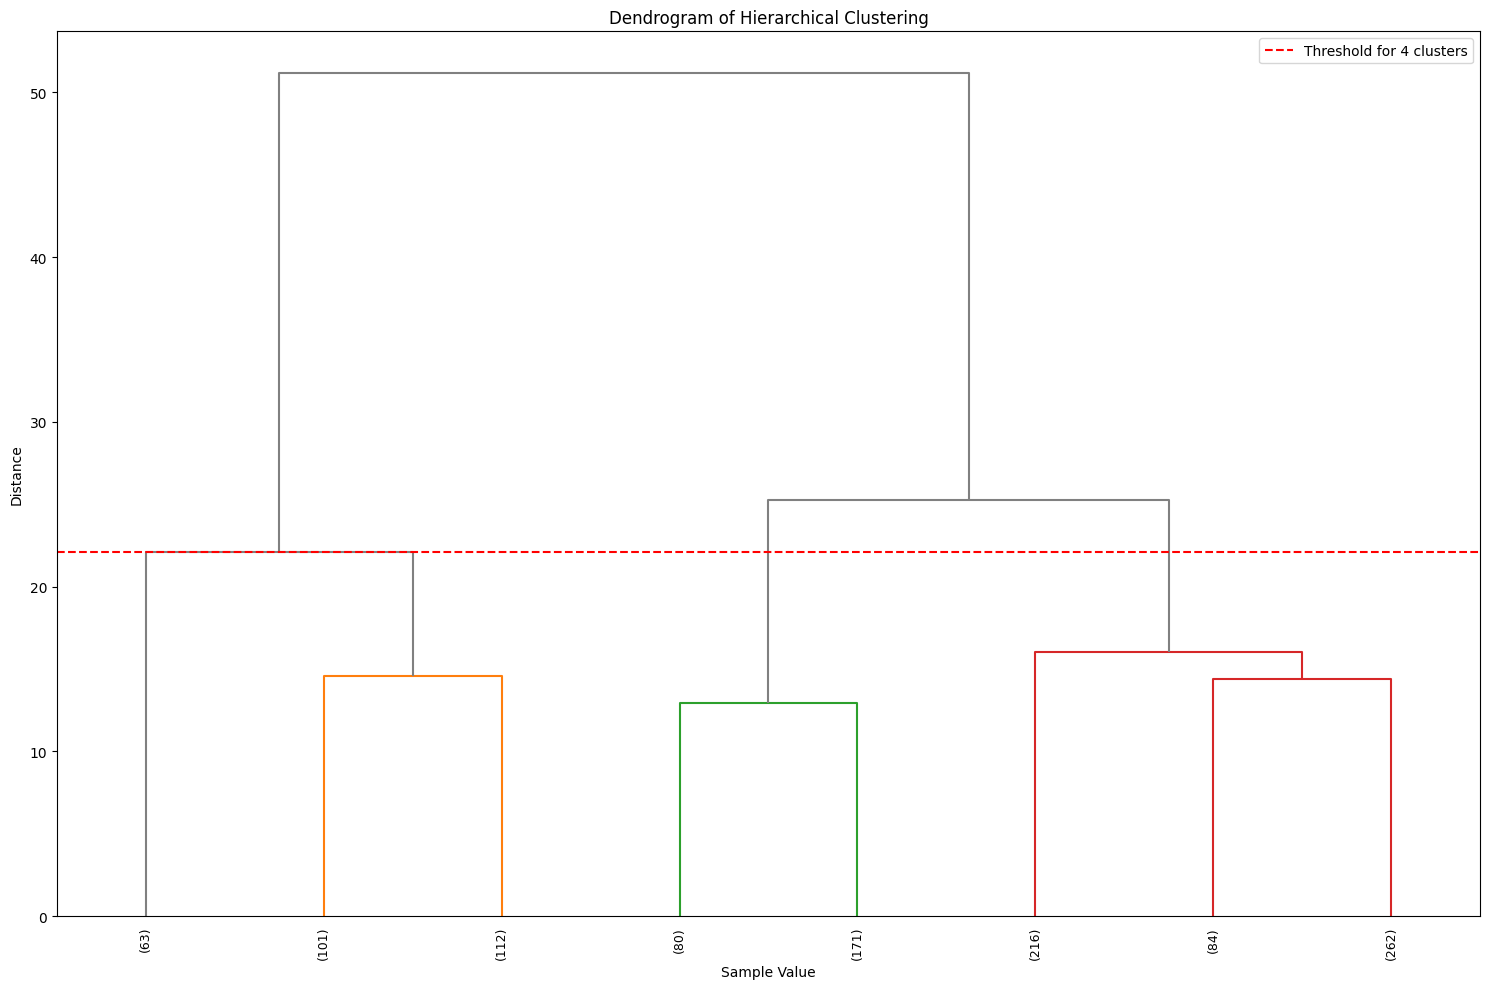

In [103]:
# Create dendrogram with focus on significant splits and original column labels
plt.figure(figsize=(15, 10))

# Calculate the color threshold to highlight significant splits
if total_merges > num_significant_splits:
    last_nonsig_merge = linkage_matrix[total_merges - num_significant_splits - 1, 2]
    first_sig_merge = linkage_matrix[total_merges - num_significant_splits, 2]
    color_threshold = (last_nonsig_merge + first_sig_merge) / 2
else:
    color_threshold = 0

# Create leaf labels based on original dataframe values
informative_column = best_features if best_features else df.columns[0]
leaf_labels = df[informative_column].astype(str).values

# Create enhanced dendrogram with custom labels
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=best_n_clusters_silhouette * 2,
    leaf_font_size=9,
    color_threshold=color_threshold,
    above_threshold_color='gray',
    labels=leaf_labels  # Use the selected column values as labels
)

# Add a horizontal line at the threshold where we get best_n_clusters_silhouette
plt.axhline(y=linkage_matrix[-(best_n_clusters_silhouette-1), 2], color='r', linestyle='--', 
           label=f'Threshold for {best_n_clusters_silhouette} clusters')
plt.legend()

plt.title(f'Dendrogram of Hierarchical Clustering')
plt.xlabel(f'Sample Value')
plt.ylabel('Distance')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Some insights from our results:

Hierarchical and K-means found the same numbers of clusters, but in somewhat different ways.  Our K-means found four groups; two separate groups of living individuals, one group of dead individuals, and one group with a high number of unknown values.  Our hierarchical group joined two unknown-value groups, then with dead, and finally with living patients.  

Our clustering results doesn't really fit any intuitive groupings on first glance, at least not in a clinical sense. Some groupings are based on clear similarities like vital_status or morphological_diagnosis as mentioned, but these do not have any discernible reason that they are more strongly correlated to one another than, say, smoking status.  

Overall, unsupervised learning is an interesting approach to the classification of lung cancer patients that requires further inspection.  We could try in the future to better quantify features like smoking status, for instance using a numeric metric like pack-years instead of a categorical result as we did here.  We could also try to resolve some of the flaws in our dataset.  When we look at our end results we can see that certain answers (No prior malignancy, No prior treatment) are greatly overrepresented in this example due to real-world medical reasons--it goes without saying that far fewer people are likely to have a reoccurence of a cancer than to have an initial cancer.  In the same vein, some cancers are much more common in the real world than other types.  With a bigger dataset perhaps we could have created a more even sample on which to run these learning algorithms on.  

Ultimately, a dataset of 1100-ish records, especially with the number of unknowns that we had to remove and calculate along the way, may be too small and sparse to achieve the sort of clustering that would lead to medical insights, but I hope that this project has the potential lead to some interesting medical questions down the line.  

Thanks for listening, and good luck on your own finals!